## **Actividad Guiada. Clasificación con KNN**

En esta actividad vamos a trabajar con un dataset con información relevante de clientes de Orange que abandonaron la empresa. Se pretende crear un modelo que, atendiendo al comportamiento del cliente y a los servicios de sus planes, estime si puede estar en peligro de abandonar (lo que en inglés se denomina como "churn") 

**Telecom Churn Datasets**

El conjunto de datos de "churn" de Orange Telecom, consta de datos de actividad del cliente (características), junto con una etiqueta de abandono que especifica si un cliente canceló la suscripción.

Cada fila representa un cliente; cada columna contiene los atributos del cliente. Los conjuntos de datos tienen los siguientes atributos o características:

* State: string
* Account length: integer
* Area code: integer
* International plan: string
* Voice mail plan: string
* Number vmail messages: integer
* Total day minutes: double
* Total day calls: integer
* Total day charge: double
* Total eve minutes: double
* Total eve calls: integer
* Total eve charge: double
* Total night minutes: double
* Total night calls: integer
* Total night charge: double
* Total intl minutes: double
* Total intl calls: integer
* Total intl charge: double
* Customer service calls: integer
* Churn: string

El "churn-bigml-20" dataset contiene 667 filas (usuarios) y 20 columnas (features).

La columna "Churn" es el objetivo a predecir.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### **Datos desbalanceados**

Existen datasets de entrenamiento para algoritmos de clasificación que se denominan como *desbalanceados*. 

¿Qué significa?

Se trata de fenómenos naturales, económicos o sociales en los que el número de muestras de una clase es mucho mayor que el número de la otra. Un caso claro es el del fraude de transacciones de tarjetas de crédito o el caso de clientes que dejan de serlo (churn).

Cuando recoges información de este tipo durante un tiempo concreto, vamos a encontrar (por norma general) más transacciones que no son fraude o que no son "churn" que casos en los que sí lo sean.

Si en un dataset la variable objetivo es binaria y el 90% del tiempo tiene el valor 0, puede darse la siguiente circunstancia:
* Un modelo tan sencillo como aquél que diga que siempre es cero tendrá un accuracy del 90%
* La métrica "accuracy" no va a ser la mejor y se podrá ver al calcular la Matriz de Confusión.

Vamos a verlo.

### **Lectura del dataset**

In [2]:
from google.colab import files

uploaded = files.upload()


Saving telecom_churn.csv to telecom_churn.csv


In [3]:
path = "/content/telecom_churn.csv"
df = pd.read_csv(path, sep=",")
print (df.shape)
df.head()

(3333, 20)


,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
df["Churn"].value_counts()

False    2850
True      483
Name: Churn, dtype: int64

In [5]:
df["Churn"].value_counts()/len(df)

False    0.855086
True     0.144914
Name: Churn, dtype: float64

En este caso, un modelo que lo único que haga sea decir que "el cliente no va a abandonar la empresa" nos daría un "accuracy" del 85%.

Vamos a ver qué ocurre con un modelo de clasificación basado en KNN.

In [6]:
len(df["State"].unique())  ## están todos los estados de EEUU

51

In [7]:
np.sum(df.isnull())

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

### **Convertir Strings a Integers**

In [8]:
from sklearn.preprocessing import LabelEncoder  

encoder = LabelEncoder()
df["International plan"] = encoder.fit_transform(df["International plan"])
df["State"] = encoder.fit_transform(df["State"])
df["Voice mail plan"] = encoder.fit_transform(df["Voice mail plan"])

In [9]:
df["Churn"] = df["Churn"].astype(int)

In [10]:
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,16,128,415,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,35,107,415,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,31,137,415,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,35,84,408,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,36,75,415,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


### **Escalado de los datos numéricos**

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit(df.iloc[:,0:-1]).transform(df.iloc[:,0:-1])

In [12]:
dfs = pd.DataFrame(scaled, columns=df.columns[:-1])
dfs.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls
0,-0.678649,0.676489,-0.523603,-0.327580,1.617086,1.234883,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,-0.465494,0.866029,-0.085008,-0.601195,-0.085690,-0.427932
1,0.603170,0.149065,-0.523603,-0.327580,1.617086,1.307948,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,0.147825,1.059390,1.240482,-0.601195,1.241169,-0.427932
2,0.333313,0.902529,-0.523603,-0.327580,-0.618396,-0.591760,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,0.198935,-0.755571,0.703121,0.211534,0.697156,-1.188218
3,0.603170,-0.428590,-0.688834,3.052685,-0.618396,-0.591760,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,-0.567714,-0.078806,-1.303026,1.024263,-1.306401,0.332354
4,0.670634,-0.654629,-0.523603,3.052685,-0.618396,-0.591760,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,1.067803,-0.276562,-0.049184,-0.601195,-0.045885,1.092641


In [13]:
dfs = pd.concat([dfs, df["Churn"]], axis=1)
dfs.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,-0.678649,0.676489,-0.523603,-0.327580,1.617086,1.234883,1.566767,0.476643,1.567036,-0.070610,-0.055940,-0.070427,0.866743,-0.465494,0.866029,-0.085008,-0.601195,-0.085690,-0.427932,0
1,0.603170,0.149065,-0.523603,-0.327580,1.617086,1.307948,-0.333738,1.124503,-0.334013,-0.108080,0.144867,-0.107549,1.058571,0.147825,1.059390,1.240482,-0.601195,1.241169,-0.427932,0
2,0.333313,0.902529,-0.523603,-0.327580,-0.618396,-0.591760,1.168304,0.675985,1.168464,-1.573383,0.496279,-1.573900,-0.756869,0.198935,-0.755571,0.703121,0.211534,0.697156,-1.188218,0
3,0.603170,-0.428590,-0.688834,3.052685,-0.618396,-0.591760,2.196596,-1.466936,2.196759,-2.742865,-0.608159,-2.743268,-0.078551,-0.567714,-0.078806,-1.303026,1.024263,-1.306401,0.332354,0
4,0.670634,-0.654629,-0.523603,3.052685,-0.618396,-0.591760,-0.240090,0.626149,-0.240041,-1.038932,1.098699,-1.037939,-0.276311,1.067803,-0.276562,-0.049184,-0.601195,-0.045885,1.092641,0


In [14]:
print (round(dfs["State"].mean(),2))
print (round(dfs["State"].std(),2))

0.0
1.0


In [15]:
dfs = dfs.sample(frac=1.0, random_state=42)

### **Selección del modelo KNN con Cross Validation**

In [16]:
X = dfs.iloc[:,0:-1]
Y = dfs.iloc[:,-1]

Vamos a calcular el valor de K que mejor "accuracy" tiene

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score

In [18]:
preds_list = []
score_list = []
k_list = []

for k in list(range(1, 20, 2)):
  knn_model = KNeighborsClassifier(n_neighbors=k, weights="uniform", metric="minkowski")
  preds = cross_val_predict(knn_model, X, Y, cv=3, method="predict", n_jobs=3)
  score = cross_val_score(knn_model, X, Y, cv=3, scoring="accuracy")
  k_list.append(k)
  preds_list.append(preds)
  score_list.append(score.mean())

In [19]:
df_scores = pd.DataFrame({"K":k_list, 
                   "score":score_list
                   })

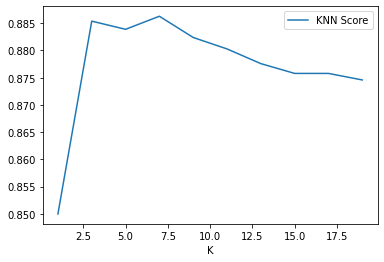

In [20]:
df_scores.set_index("K")["score"].plot(label="KNN Score")
plt.legend()
plt.show();

### **Entrenamiento y Evaluación del modelo**

In [21]:
knn_model = KNeighborsClassifier(n_neighbors=7, weights="uniform", metric="minkowski")
preds = cross_val_predict(knn_model, X, Y, cv=3, method="predict", n_jobs=3)
score = cross_val_score(knn_model, X, Y, cv=3, scoring="accuracy", n_jobs=3)
score

array([0.88028803, 0.89288929, 0.88568857])

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y, preds)

##          predicciones
##            0      1
##       0   TN     FP
## real
##       1   FN     TP

array([[2811,   39],
       [ 340,  143]])

### **Recall, Precision y F1-Score**

De lo anterior podemos sacar las siguientes **Conclusiones**

* El modelo KNN en su mejor versión sólo supera al modelo simple en un 3%

* Cuando miramos la Matriz de Confusión podemos ver que, de los 483 positivos reales sólo ha acertado en 143 casos: un 30% de acierto.

*¿Cómo se denomina esta métrica?*

$$ Recall =  \frac{TP}{TP+FN}$$ 

* También podemos ver que, de todas las ocasiones en las que KNN nos dice que existe abandono (182), hay 143 en las que ha acertado: un 79%

*¿Cómo se denomina esta métrica?*

$$ Precision =  \frac{TP}{TP+FP}$$ 

Así, tenemos un modelo con un alto valor de Precision pero uno muy bajo de Recall. Atendiendo al problema que se quiera resolver podremos querer subir más uno u otro. En la mayoría de las ocasiones habrá que decidir porque cuando baje uno subirá el otro.

* De los resultados anteriores, se puede deducir que "accuracy" no es la mejor forma de evaluar modelos de clasificación cuando los datos está desbalanceados

Por tanto:

**Hay que calcular las Matriz de Confusión siempre, y con más razón cuando el dataset esté desbalanceado**

In [24]:
from sklearn.metrics import classification_report
print(f"Informe de Clasificación:\n"
      f"{classification_report(Y, preds)}")

Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2850
           1       0.79      0.30      0.43       483

    accuracy                           0.89      3333
   macro avg       0.84      0.64      0.68      3333
weighted avg       0.88      0.89      0.86      3333



Aunque hay diferentes valores de Precision y Recall según la clase, nos vamos a fijar en la fila donde dice 1. Ahí es donde se produce el fallo del modelo. Al ser un dataset desbalanceado las métricas para 0 son muy buenas.

Por tanto, aquí tenemos el 30% y el 79% calculados anteriormente. En cuanto a la métrica F1 decir que nos servirá si queremos comparar modelos diferentes. En su fórmula se combinan los valores de Precision y Recall:

$$ F1 =  \frac{precision*recall}{precision+recall}$$ 

En este caso, sigue siendo baja.

Así que, ¿qué vamos a hacer ahora?

Vamos a dibujar una gráfica donde podamos decidir cómo queremos que sea nuestro modelo sin tener en cuenta "accuracy" sino la balanza entre un buen recall o una buena precision. Para ello vamos a necesitar saber la probabilidad que otorga KNN a cada una de sus predicciones.

In [25]:
knn_model = KNeighborsClassifier(n_neighbors=12, weights="uniform", metric="minkowski")
probs = cross_val_predict(knn_model, X, Y, cv=3, method="predict_proba", n_jobs=3)
preds = cross_val_predict(knn_model, X, Y, cv=3, method="predict", n_jobs=3)

In [26]:
probs  ## nos devuelve dos probabilidades, una para cada clase

array([[0.83333333, 0.16666667],
       [1.        , 0.        ],
       [0.83333333, 0.16666667],
       ...,
       [0.91666667, 0.08333333],
       [1.        , 0.        ],
       [0.91666667, 0.08333333]])

In [27]:
probs[:,1]

array([0.16666667, 0.        , 0.16666667, ..., 0.08333333, 0.        ,
       0.08333333])

In [28]:
df_dict = {"prob_class0": probs[:,0],
           "prob_class1": probs[:,1],
           "preds":preds}

In [29]:
df_probs = pd.DataFrame(df_dict)
df_probs.head()

,prob_class0,prob_class1,preds
0,0.833333,0.166667,0
1,1.000000,0.000000,0
2,0.833333,0.166667,0
3,0.916667,0.083333,0
4,1.000000,0.000000,0


In [30]:
df_probs[df_probs["preds"]==1]["prob_class0"].max()

0.4166666666666667

Por defecto, KNN predice 0 o 1, si el valor de la probabilidad supera el 50%

Esto es muy importante porque se va a convertir en nuestra herramienta para decidir si queremos mejorar Recall o Precision.

* Si subimos el límite de 50% a 70%, ¿qué ocurre?

Al ser más estrictos para que una predicción sea 1, tendremos menos FP y aumentará la Precision.

* Si bajamos el límite de 50% a 20%, ¿qué ocurre?

Al ser menos estrictos para que una predicción sea 1, tendremos menos FN y aumentará Recall.





In [31]:
from sklearn.metrics import precision_recall_curve
precision, recall, limite = precision_recall_curve(Y,probs[:,1])

In [32]:
precision

array([0.14491449, 0.23667029, 0.40414508, 0.55917667, 0.64251208,
       0.72363636, 0.78106509, 0.87058824, 0.91304348, 0.94736842,
       1.        , 1.        , 1.        , 1.        ])

In [33]:
recall

array([1.        , 0.90062112, 0.80745342, 0.67494824, 0.55072464,
       0.41200828, 0.27329193, 0.15320911, 0.08695652, 0.03726708,
       0.01863354, 0.00828157, 0.00414079, 0.        ])

In [34]:
limite

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        ])

<br>
<p> <mark>SABÍAS QUE...</mark> </p>
<hr>


Precisión y Recall, es lo mismo que Sensibilidad y Especificidad que se llaman en medicina, fíjate en ambos artículos:

[Precision y Recall](https://en.wikipedia.org/wiki/Precision_and_recall)

[Sensibilidad y Especificidad](https://es.wikipedia.org/wiki/Sensibilidad_y_especificidad)

¿Recuerdas que lo viste en el módulo 2 en la parte de probabilidad?

### **Curva Precision vs Recall**

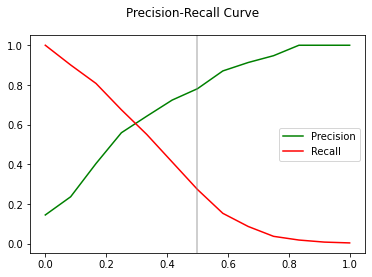

In [35]:
plt.plot(limite, precision[:-1], c="green", label="Precision")
plt.plot(limite, recall[:-1], c="red", label="Recall")
plt.axvline(0.5, alpha=0.5, c="gray")
plt.suptitle("Precision-Recall Curve")
plt.legend()
plt.show()

La línea vertical que sube por 0.5 corta a cada una de las curvas en sus valores: 0.30 y 0.79

En el caso en el que estamos, ¿qué preferimos?

Se entiende que si tenemos una empresa y queremos contactar con aquéllos clientes que parece que puedan abandonarnos, preferiría encontrar a todos los posibles aunque para ello contactara con clientes satisfechos. 

Eso significa, disminuir los Falsos Negativos (FN) --> debemos aumentar Recall

Atendiendo a la curva de arriba debemos disminuir el límite de 50%

Vamos a probar con 30, 20 y 10%

In [36]:
df_probs["preds_10"] = 0
df_probs["preds_20"] = 0
df_probs["preds_30"] = 0

df_probs.loc[df_probs["prob_class1"]>0.1, "preds_10"] = 1
df_probs.loc[df_probs["prob_class1"]>0.2, "preds_20"] = 1
df_probs.loc[df_probs["prob_class1"]>0.3, "preds_30"] = 1

In [37]:
df_probs

,prob_class0,prob_class1,preds,preds_10,preds_20,preds_30
0,0.833333,0.166667,0,1,0,0
1,1.000000,0.000000,0,0,0,0
2,0.833333,0.166667,0,1,0,0
3,0.916667,0.083333,0,0,0,0
4,1.000000,0.000000,0,0,0,0
...,...,...,...,...,...,...
3328,0.750000,0.250000,0,1,1,0
3329,1.000000,0.000000,0,0,0,0
3330,0.916667,0.083333,0,0,0,0
3331,1.000000,0.000000,0,0,0,0


In [38]:
confusion_matrix(Y, df_probs["preds_10"].values)

##          predicciones
##            0      1
##       0   TN     FP
## real
##       1   FN     TP

array([[2275,  575],
       [  93,  390]])

In [39]:
confusion_matrix(Y, df_probs["preds_20"].values)

array([[2593,  257],
       [ 157,  326]])

In [40]:
confusion_matrix(Y, df_probs["preds_30"].values)

array([[2702,  148],
       [ 217,  266]])

Éste es el momento en el que hay que decidirse. A partir de los resultados la empresa tendrá que decidir qué tipo de contacto realizar. Hay que tener en cuenta que, en el caso del 10% vamos a contactar con más clientes satisfechos que insatisfechos. Si hacemos oferta a todos ellos la empresa puede perder muchos ingresos. Pero si se contacta para saber si tienen algún problema es posible que valga la pena.

